## 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


df = pd.read_csv('../renttherunway_data.csv')
data = df.copy()
data.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [2]:
data.describe()

,user_id,item_id,rating,size,age
count,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


In [3]:
data.isnull().sum()

fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text          68
body type         14637
review_summary      347
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

#### bust size, rented for, review_text, review_summary, review_date 컬럼 삭제

In [4]:
# 지정한 컬럼 삭제
columns_to_drop = ['bust size', 'rented for', 'review_text', 'review_summary', 'review_date']
data = data.drop(columns=columns_to_drop)

data.head()

,fit,user_id,item_id,weight,rating,body type,category,height,size,age
0,fit,420272,2260466,137lbs,10.0,hourglass,romper,"5' 8""",14,28.0
1,fit,273551,153475,132lbs,10.0,straight & narrow,gown,"5' 6""",12,36.0
2,fit,360448,1063761,NaN,10.0,NaN,sheath,"5' 4""",4,116.0
3,fit,909926,126335,135lbs,8.0,pear,dress,"5' 5""",8,34.0
4,fit,151944,616682,145lbs,10.0,athletic,gown,"5' 9""",12,27.0


#### 상품 id 분석

In [5]:
# item_id별 등장 횟수 집계
item_counts = data['item_id'].value_counts().sort_index()
item_counts_df = item_counts.reset_index()
item_counts_df.columns = ['item_id', 'count']
item_counts_sorted = item_counts_df.sort_values(by='count', ascending=False).reset_index(drop=True)
top_10_items = item_counts_sorted.head(10)

print(top_10_items)


   item_id  count
0   126335   2241
1   174086   1724
2   123793   1714
3   132738   1582
4   145906   1478
5   127865   1393
6   136110   1197
7   137585   1100
8   131533   1091
9   172027    984


#### `weight` 컬럼: 단위 변환 후 결측치 처리

In [6]:
# weight → lbs 숫자 추출 → kg 변환
data['weight'] = data['weight'].str.extract(r'(\d+)').astype(float)
data['weight'] = data['weight'] * 0.453592

# 1. weight가 null인 데이터 삭제
df_weight_dropna = data.dropna(subset=['weight'])

In [7]:
# 2. 평균으로 대체
mean_weight = df_weight_dropna['weight'].mean()
data['weight'] = data['weight'].fillna(mean_weight)

data[['weight']].describe()

,weight
count,192544.000000
mean,62.319780
std,9.127528
min,22.679600
25%,56.699000
50%,62.319780
75%,65.770840
max,136.077600


In [8]:
# 3. 중앙값으로 대체
median_weight = df_weight_dropna['weight'].median()
data['weight'] = data['weight'].fillna(median_weight)

data[['weight']].describe()

,weight
count,192544.000000
mean,62.319780
std,9.127528
min,22.679600
25%,56.699000
50%,62.319780
75%,65.770840
max,136.077600


In [9]:
# 4. 최빈값으로 대체
mode_weight = df_weight_dropna['weight'].mode().iloc[0]
data['weight'] = data['weight'].fillna(mode_weight)

data[['weight']].describe()

,weight
count,192544.000000
mean,62.319780
std,9.127528
min,22.679600
25%,56.699000
50%,62.319780
75%,65.770840
max,136.077600


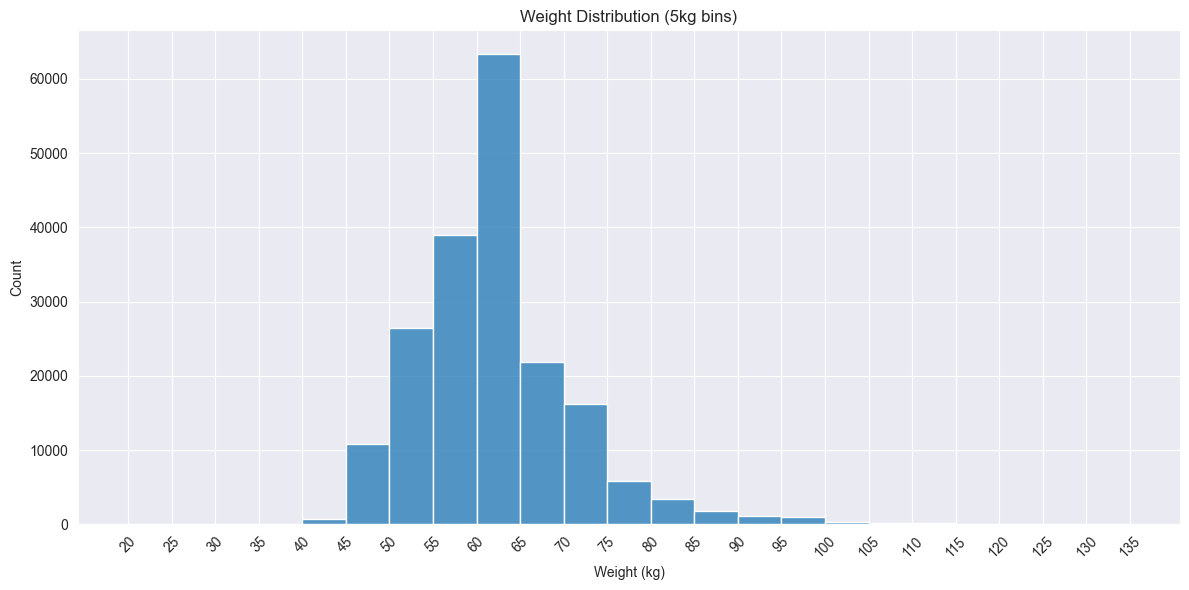

In [10]:
# 5kg 간격 bin 정의
bin_edges= np.arange(start=int(data['weight'].min() // 5 * 5),
                          stop=int(data['weight'].max() // 5 * 5 + 5),
                          step=5)

# 시각화
plt.figure(figsize=(12, 6))
sns.histplot(data['weight'], bins=bin_edges, kde=False)
plt.title("Weight Distribution (5kg bins)")
plt.xlabel("Weight (kg)")
plt.ylabel("Count")
plt.xticks(bin_edges, rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#### `height` 컬럼: 단위 변환 후 결측치 처리

In [11]:
def height_to_cm(h):
    if isinstance(h, str):
        match = re.match(r"(\d+)' (\d+)", h)
        if match:
            feet = int(match.group(1))
            inches = int(match.group(2))
            total_inches = feet * 12 + inches
            return total_inches * 2.54
    return np.nan

data['height'] = data['height'].apply(height_to_cm)

# height 결측치 제거
data = data.dropna(subset=['height'])

data[['height']].describe()
data.isnull().sum()

fit              0
user_id          0
item_id          0
weight           0
rating          82
body type    14508
category         0
height           0
size             0
age            952
dtype: int64

In [12]:
data[['height']].describe()

,height
count,191867.000000
mean,165.888978
std,6.765239
min,137.160000
25%,160.020000
50%,165.100000
75%,170.180000
max,198.120000


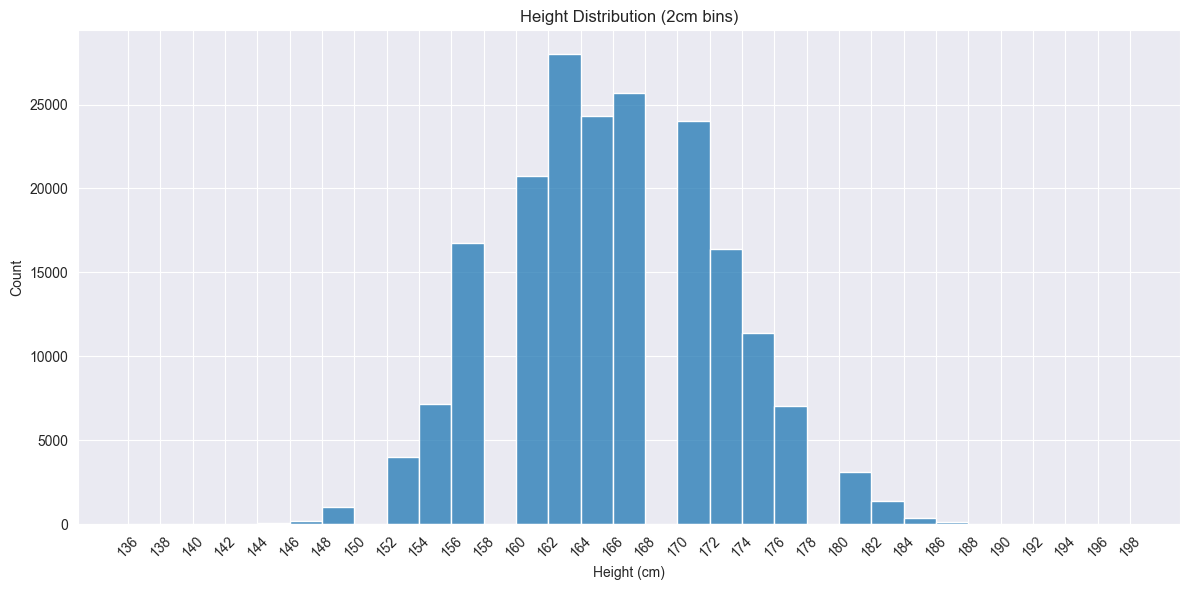

In [13]:
# 2cm 간격의 bin 정의
bin_edges = np.arange(start=int(data['height'].min() // 2 * 2),
                          stop=int(data['height'].max() // 2 * 2 + 2),
                          step=2)

# 히스토그램 시각화
plt.figure(figsize=(12, 6))
sns.histplot(data['height'], bins=bin_edges, kde=False)
plt.title("Height Distribution (2cm bins)")
plt.xlabel("Height (cm)")
plt.ylabel("Count")
plt.xticks(bin_edges, rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#### `age`: 이상치 및 결측치 제거

In [14]:
data['age'] = data['age'].where((data['age'] < 100) & (data['age'] > 19), np.nan)
data = data.dropna(subset=['age'])

data[['age']].describe()

,age
count,189672.000000
mean,33.950388
std,7.825581
min,20.000000
25%,29.000000
50%,32.000000
75%,37.000000
max,99.000000


#### `rating`: 2, 4, 6, 8, 10 -> 1, 2, 3, 4, 5 & 결측치 제거

In [15]:
data['rating'] = (data['rating'] // 2)
data = data.dropna(subset=['rating'])

data[['rating']].describe()

,rating
count,189591.000000
mean,4.545548
std,0.715359
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


#### `body type`: 원핫 인코딩

In [16]:
body_type_encoded = pd.get_dummies(data['body type'], prefix='body_type', dummy_na=True)

# 인코딩 컬럼 목록 확인
encoded_columns = body_type_encoded.columns.tolist()
print(encoded_columns)

data = data.drop(columns=['body type'])
data = pd.concat([data, body_type_encoded], axis=1)

['body_type_apple', 'body_type_athletic', 'body_type_full bust', 'body_type_hourglass', 'body_type_pear', 'body_type_petite', 'body_type_straight & narrow', 'body_type_nan']


In [17]:
data.head()

,fit,user_id,item_id,weight,rating,category,height,size,age,body_type_apple,body_type_athletic,body_type_full bust,body_type_hourglass,body_type_pear,body_type_petite,body_type_straight & narrow,body_type_nan
0,fit,420272,2260466,62.142104,5.0,romper,172.72,14,28.0,False,False,False,True,False,False,False,False
1,fit,273551,153475,59.874144,5.0,gown,167.64,12,36.0,False,False,False,False,False,False,True,False
3,fit,909926,126335,61.234920,4.0,dress,165.10,8,34.0,False,False,False,False,True,False,False,False
4,fit,151944,616682,65.770840,5.0,gown,175.26,12,27.0,False,True,False,False,False,False,False,False
5,fit,734848,364092,62.595696,4.0,dress,172.72,8,45.0,False,True,False,False,False,False,False,False


#### `category`: 원핫 인코딩 or 레이블 인코딩 -> 보류

In [18]:
#category_encoded = pd.get_dummies(data['category'], prefix='category')

#### `fit` : 원핫 인코딩

In [19]:
fit_encoded = pd.get_dummies(data['fit'], prefix='fit')

# 인코딩 컬럼 목록 확인
encoded_columns = fit_encoded.columns.tolist()
print(encoded_columns)

data = data.drop(columns=['fit'])
data = pd.concat([data, fit_encoded], axis=1)

['fit_fit', 'fit_large', 'fit_small']


#### `size`: 정규화 or 표준화

In [20]:
data['size'].describe()

count    189591.000000
mean         12.256621
std           8.493520
min           0.000000
25%           8.000000
50%          12.000000
75%          16.000000
max          58.000000
Name: size, dtype: float64

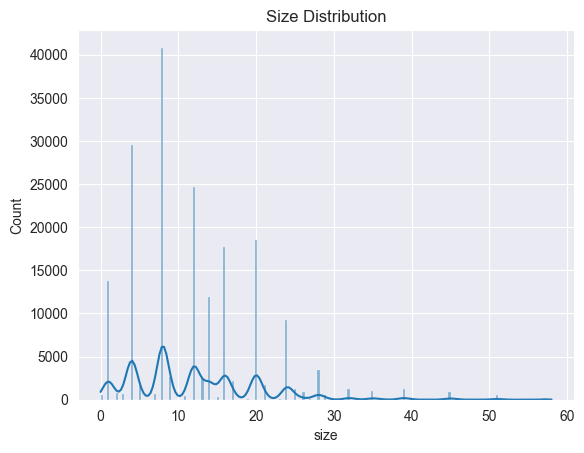

In [21]:
sns.histplot(df['size'], kde=True)
plt.title('Size Distribution')
plt.show()

In [22]:
data.isnull().sum()

user_id                        0
item_id                        0
weight                         0
rating                         0
category                       0
height                         0
size                           0
age                            0
body_type_apple                0
body_type_athletic             0
body_type_full bust            0
body_type_hourglass            0
body_type_pear                 0
body_type_petite               0
body_type_straight & narrow    0
body_type_nan                  0
fit_fit                        0
fit_large                      0
fit_small                      0
dtype: int64

### Kmeans 클러스터링 모델 적용

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from tqdm import tqdm

# 컬럼 정의
numeric_cols = ['age', 'size', 'weight', 'height']
encoded_cols = [col for col in data.columns if col.startswith(('body_type_', 'fit'))]

# 전처리 대상 컬럼 추출
feature_cols = numeric_cols + encoded_cols
data_kmeans = data[feature_cols].sample(n=50000, random_state=42)

# 수치형, 범주형 컬럼 분리
X_numeric = data_kmeans[numeric_cols]
X_encoded = data_kmeans[encoded_cols]

# 1. 수치형 스케일링
scaler = MinMaxScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# 2. 범주형 컬럼 가중치 조절
weight = 0.6
X_encoded_weighted = X_encoded.to_numpy() * weight

# 3. 전체 컬럼 결합
X_final = np.hstack([X_numeric_scaled, X_encoded_weighted])

In [24]:
# # 4. KMeans 클러스터링 및 평가
# for k in tqdm(range(20, 21)):
#     model = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = model.fit_predict(X_final)
#     sil_score = silhouette_score(X_final, labels)
#     print(f"[k={k}] Silhouette Score: {sil_score:.4f}")

#### 하이퍼파라미터 튜닝

In [ ]:
# 5. 하이퍼파라미터 튜닝 범위
scalers = {
    'minmax': MinMaxScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}
algorithms = ['auto', 'full', 'elkan']
n_init_options = [10, 20]

# 6. 튜닝 실행
results = []
best_score = -1
best_params = None

for scaler_name, scaler in scalers.items():
    X_numeric_scaled = scaler.fit_transform(X_numeric)

    X_final = np.hstack([X_numeric_scaled, X_encoded_weighted])

    for algorithm in algorithms:
        for n_init in n_init_options:
            for k in range(3, 21):
                try:
                    model = KMeans(
                        n_clusters=k,
                        init='k-means++',
                        n_init=n_init,
                        max_iter=300,
                        tol=1e-4,
                        algorithm=algorithm,
                        random_state=42
                    )
                    labels = model.fit_predict(X_final)
                    score = silhouette_score(X_final, labels)
                    results.append({
                        'silhouette_score': score,
                        'k': k,
                        'scaler': scaler_name,
                        'algorithm': algorithm,
                        'n_init': n_init
                    })
                    if score > best_score:
                        best_score = score
                        best_params = (score, k, scaler_name, algorithm, n_init)

                except:
                    continue

# 7. 결과 출력
df_results = pd.DataFrame(results)
print("Best Score:", round(best_score, 4))
print("Best Parameters:", best_params)
print(df_results.sort_values(by='silhouette_score', ascending=False).head(10))

3 10 elkan 0.2438235980945728
5 10 elkan 0.3414261223955111
6 10 elkan 0.4259842057760716
7 10 elkan 0.47089534860685744
8 10 elkan 0.503192458627264
9 10 elkan 0.5364321638718975
10 10 elkan 0.5568858450529077
11 10 elkan 0.574392535955268
12 10 elkan 0.5947829762547345
13 10 elkan 0.6112372387107445
14 10 elkan 0.6258010493564371
15 10 elkan 0.6382510811254909
16 10 elkan 0.6502521504272243
18 10 elkan 0.667931413033863
19 10 elkan 0.6711763215717551
20 10 elkan 0.5927424977172518


#### 가중치를 주지 않았을 때 실루엣 스코어: 0.7981

In [15]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
#
# # feature 선택
# numeric_cols = ['age', 'size', 'weight', 'height']
# encoded_cols = [col for col in data.columns if (col.startswith('body_type_') or col.startswith('fit'))]
#
# feature_cols = numeric_cols + encoded_cols
# data_kmeans = data[feature_cols].dropna()
#
# # 표준화 및 클러스터링
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(data_kmeans)
#
# # k = 3 ~ 15로 실루엣 스코어 평가
# # for k in range(3, 16):
# #     model = KMeans(n_clusters=k, random_state=42)
# #     labels = model.fit_predict(X_scaled)
# #     sil_score = silhouette_score(X_scaled, labels)
# #     print(f"{k} clusters 완료")
# #     print(f"Silhouette Score: {sil_score}")

In [16]:
# # k = 20
# kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
# data_kmeans['cluster'] = kmeans.fit_predict(X_scaled)
#
# # 실루엣 점수 계산
# sil_score = silhouette_score(X_scaled, data_kmeans['cluster'])
# sil_score

0.7981828912343766

#### 클러스터별 인기상품 추출

In [58]:
# print(data_kmeans['cluster'])
# data_kmeans = data[feature_cols + ['item_id', 'rating']].dropna()


0          6
1         13
3          2
4          6
5          0
          ..
192539     0
192540    14
192541     6
192542    19
192543    19
Name: cluster, Length: 189591, dtype: int32


In [59]:
# # 클러스터별 추천 상품 (평균 평점 상위 10개씩)
# top_items_by_cluster = (
#     data_kmeans.groupby(['cluster', 'item_id'])['rating']
#     .mean()
#     .reset_index()
#     .sort_values(['cluster', 'rating'], ascending=[True, False])
#     .groupby('cluster')
#     .head(10)
#     .reset_index(drop=True)
# )
#
# print(top_items_by_cluster)

KeyError: 'item_id'